We'd like to study how out model performs when applying various analyses to datasets not seen during its training. Here, we examine this problem using the set of human CDR3 TRB sequences.

In [ ]:
cd ..

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
!hostname

In [ ]:
import os, sys
import logging
import json
import tempfile
import itertools
import collections
import importlib
import matplotlib
import tqdm
import numpy as np
import pandas as pd
from sklearn import metrics
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns

import anndata as ad
import scanpy as sc

import torch
import torch.nn as nn
import skorch
import skorch.helper

import ipywidgets
import jupyter
from ipywidgets import FloatProgress

from transformers import BertModel, BertForMaskedLM, BertTokenizer, FeatureExtractionPipeline

SRC_DIR = "tcr"
assert os.path.isdir(SRC_DIR), f"Cannot find src dir: {SRC_DIR}"
sys.path.append(SRC_DIR)
from tcr import custom_metrics
#import data_loader as dl
from tcr import featurization as ft
from tcr import canonical_models as models
from tcr import model_utils
from tcr import muscle
from tcr import plot_utils
from tcr import utils
from lab_notebooks.utils import TRANSFORMER, DEVICE
MODEL_DIR = os.path.join(SRC_DIR, "models")
sys.path.append(MODEL_DIR)
import transformer_custom as trans
import conv

FILT_EDIT_DIST = True

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots/CDR3_data_plots")
if not os.path.isdir(PLOT_DIR):
    os.makedirs(PLOT_DIR)
PLOT_DIR

In [39]:
# generate matplotlib colors with names (for UMAP)
import matplotlib.colors as mcolors
def format_color_groups(df, color):
    x = df.copy()
    i = 0

    for factor in color:
        x.iloc[i, :-1] = ''
        style = f'background-color: {color[i]}'
        x.loc[i, 'display color as background'] = style
        i = i + 1

    return x

colors = {
    'name': mcolors.CSS4_COLORS.keys(),
    'hex': mcolors.CSS4_COLORS.values()
}
df_colors = pd.DataFrame(colors)
df_colors['rgb'] = df_colors['hex'].apply(mcolors.hex2color)
df_colors['rgb'] = df_colors['rgb'].apply(lambda x:[round(c, 5) for c in x])
df_colors['display color as background'] = ''
df_colors.style.apply(format_color_groups, color=df_colors.hex,  axis=None)



,name,hex,rgb,display color as background
0,aliceblue,#F0F8FF,"[0.94118, 0.97255, 1.0]",
1,antiquewhite,#FAEBD7,"[0.98039, 0.92157, 0.84314]",
2,aqua,#00FFFF,"[0.0, 1.0, 1.0]",
3,aquamarine,#7FFFD4,"[0.49804, 1.0, 0.83137]",
4,azure,#F0FFFF,"[0.94118, 1.0, 1.0]",
5,beige,#F5F5DC,"[0.96078, 0.96078, 0.86275]",
6,bisque,#FFE4C4,"[1.0, 0.89412, 0.76863]",
7,black,#000000,"[0.0, 0.0, 0.0]",
8,blanchedalmond,#FFEBCD,"[1.0, 0.92157, 0.80392]",
9,blue,#0000FF,"[0.0, 0.0, 1.0]",


In [40]:
# list of color names
list(df_colors['name'][5:20])
df_colors[5:20]

,name,hex,rgb,display color as background
5,beige,#F5F5DC,"[0.96078, 0.96078, 0.86275]",
6,bisque,#FFE4C4,"[1.0, 0.89412, 0.76863]",
7,black,#000000,"[0.0, 0.0, 0.0]",
8,blanchedalmond,#FFEBCD,"[1.0, 0.92157, 0.80392]",
9,blue,#0000FF,"[0.0, 0.0, 1.0]",
10,blueviolet,#8A2BE2,"[0.54118, 0.16863, 0.88627]",
11,brown,#A52A2A,"[0.64706, 0.16471, 0.16471]",
12,burlywood,#DEB887,"[0.87059, 0.72157, 0.52941]",
13,cadetblue,#5F9EA0,"[0.37255, 0.61961, 0.62745]",
14,chartreuse,#7FFF00,"[0.49804, 1.0, 0.0]",


#### Display Sick/Healthy patients on UMAP

#### Prepare data

In [ ]:
nofar_data_with_label_sick = pd.read_csv("/home/dsi/rgoldner/CDR3_data/nofar_BCRA_CDR3_public_private_with_label.csv")
nofar_data_with_label_sick

In [ ]:
collections.Counter(nofar_data_with_label_sick['label'])

In [ ]:
# sick patients
only_sick_patients_df = nofar_data_with_label_sick[nofar_data_with_label_sick["label"]=='BRCA_HER2']
only_sick_patients_df

In [ ]:
# healthy patients
only_healthy_patients_df = nofar_data_with_label_sick[nofar_data_with_label_sick["label"]=='Control']
only_healthy_patients_df

In [ ]:
# select only TCR beta rows (nofar data)

# sick
#tcrb_data_sample = only_sick_patients_df[only_sick_patients_df["locus"] == 'Beta']

# healthy
tcrb_data_sample = only_healthy_patients_df[only_healthy_patients_df["locus"] == 'Beta']
collections.Counter(tcrb_data_sample['locus'])

#### Create and Display embeddings

In [ ]:
# create embeddings
embedding_kwargs = {"method": "mean", "layers": [-1]}
tcrb_embeddings = model_utils.get_transformer_embeddings(
    TRANSFORMER, list(tcrb_data_sample['Sequences']), **embedding_kwargs,
    device=DEVICE,)
tcrb_embeddings.shape

In [ ]:
# calculate pca, umap of embeddings
tcrb_embeddings_adata = ad.AnnData(
    tcrb_embeddings,
    obs=tcrb_data_sample,
)
sc.pp.pca(tcrb_embeddings_adata, n_comps=50)
sc.pp.neighbors(tcrb_embeddings_adata)
sc.tl.umap(tcrb_embeddings_adata)
tcrb_embeddings_adata

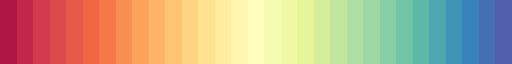

In [51]:
from matplotlib.colors import ListedColormap
# Create colormap of 16 shades of blues
color_map = ListedColormap(sns.color_palette("Spectral", 31))

# Reverse the cmap colors
#cmap = cmap.reversed()
color_map

In [ ]:
colors = ['gold', 'darkblue']#, 'maroon'] #cmap=plt.get_cmap('Set1)'

importlib.reload(plot_utils)
plot_utils.plot_anndata_rep(
    tcrb_embeddings_adata,
    color='label',
    direct_label=False,
    #cmap= color_map,
    cmap=matplotlib.colors.ListedColormap(colors),
    title="UMAP of Embeddings of Sick Patients",
    #title="UMAP of Embeddings of Healthy Patients",
    legend_size=7,
    fname=os.path.join(PLOT_DIR, "tcr_model_nofar_data_umap_sick.pdf"),
    #fname=os.path.join(PLOT_DIR, "tcr_model_nofar_data_umap_healthy.pdf"),
).show()

### tSNE of Embeddings

In [ ]:
# tcrb_embeddings_adata_tsne = ad.AnnData(
#     tcrb_embeddings,
#     obs=tcrb_data_sample,
# )
# sc.pp.pca(tcrb_embeddings_adata_tsne, n_comps=50)
# sc.pp.neighbors(tcrb_embeddings_adata_tsne)
# sc.tl.tsne(tcrb_embeddings_adata_tsne)
# tcrb_embeddings_adata_tsne

In [ ]:
# colors = ['mistyrose', 'blue'] #cmap=plt.get_cmap('Set1)'
# importlib.reload(plot_utils)
# plot_utils.plot_anndata_rep(
#     tcrb_embeddings_adata_tsne, color='Private_Public_label', direct_label=False, cmap=matplotlib.colors.ListedColormap(colors), representation = "tsne",
#     title="tSNE of Embeddings",
#     legend_size=7,
#     fname=os.path.join(PLOT_DIR, "tcr_model_db_data_tsne.pdf"),
# ).show()